## Experiment configuration 3 of protocol
- Date: 20/09/2021

## Configuration
	3. (3) Incremental guided retraining starting from the original
	model using the new adversarial inputs and
	original training set
		a. (a) The new inputs are added to the training set. Incremental
		training, starting with the previous
		trained model. Using at each iteration a subset of
the new training set.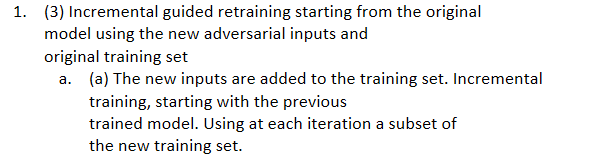

In [1]:
import argparse

import numpy as np
import tensorflow as tf
import keras.backend as K

import matplotlib.pyplot as plt

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.regularizers import l2

import glob
import os
import cv2
import keras


import time
import argparse

from tqdm import tqdm

from keras.models import load_model, Model


In [2]:
# utils for project
import project_utils as utils

In [3]:
x_train,y_train = utils.get_data("Train")
x_val,y_val = utils.get_data("Val")
x_test,y_test = utils.get_data("Test")

In [4]:
x_train_and_adversary,y_train_and_adversary = utils.get_data("Train_and_adversary")

In [5]:
x_adversary_training = x_train_and_adversary[len(x_train):]
print(len(x_adversary_training))
y_adversary_training = y_train_and_adversary[len(y_train):]

print(len(y_adversary_training))

5000
5000


In [6]:
# Obtaining adversarial examples for testing 
x_test_and_adversary,y_test_and_adversary = utils.get_adversarial_data('Test_fgsm') 

In [8]:
x_adversary_test_fgsm = x_test_and_adversary[len(x_test):]
print(len(x_adversary_test_fgsm))
y_adversary_test_fgsm = y_test_and_adversary[len(y_test):]

print(len(y_adversary_test_fgsm))

3923
3923


In [7]:
x_test_and_adversary_jsma,y_test_and_adversary_jsma = utils.get_adversarial_data('Test_jsma') 

In [9]:
x_adversary_test_jsma = x_test_and_adversary_jsma[len(x_test):]
print(len(x_adversary_test_jsma))
y_adversary_test_jsma = y_test_and_adversary_jsma[len(y_test):]

print(len(y_adversary_test_jsma))

3923
3923


## ----

In [10]:
# Original model 
model_dir = "C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/models/tf_model_25-06"

In [11]:
model_original = utils.My_model(True, model_dir)

Model loaded correctly


## Obtaining new LSA and DSA values 

- We need the module 'deepo'

In [1]:

cd "C:\Users\fjdur\Desktop\upc\project_notebooks\deepimportance_code_release"


C:\Users\fjdur\Desktop\upc\project_notebooks\deepimportance_code_release


In [19]:
# from 07_notebook
from utils import filter_val_set, get_trainable_layers
from utils import generate_adversarial, filter_correct_classifications
from coverages.idc import ImportanceDrivenCoverage
from coverages.neuron_cov import NeuronCoverage
from coverages.tkn import DeepGaugeLayerLevelCoverage
from coverages.kmn import DeepGaugePercentCoverage
from coverages.ss import SSCover
from coverages.sa import SurpriseAdequacy


In [22]:
trainable_layers = get_trainable_layers(model_original.model)
non_trainable_layers = list(set(range(len(model_original.model.layers))) - set(trainable_layers))
print('Trainable layers: ' + str(trainable_layers))
print('Non trainable layers: ' + str(non_trainable_layers))

Trainable layers: [0, 1, 4, 5, 8, 9, 13, 15, 17]
Non trainable layers: [2, 3, 6, 7, 10, 11, 12, 14, 16]


In [24]:
model_original.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0

In [25]:
subject_layer = trainable_layers[-2]
layer_names = [model_original.model.layers[-3].name]
upper_bound = 2000
layer_names

['dense_1']

In [26]:
from coverages import sa
from datetime import datetime

In [27]:
start_time = datetime.now()
#surprise of all inputs wrt to the original inputs
target_lsa = sa.fetch_lsa(model_original.model, x_train, x_train_and_adversary,
                                   "conf_3_sep", layer_names,
                                   43, True,
                                   1e-05, './sa_data', "model_original_c3_sep")


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

[train] Model serving
18
246/246 [==============================] - 44s 179ms/step
[train] Processing ATs
Layer: dense_1
train ATs is saved at ./sa_data\model_original_c3_sep_train_dense_1_ats.npy
[conf_3_sep] Model serving
18
285/285 [==============================] - 54s 189ms/step
[conf_3_sep] Processing ATs
Layer: dense_1
conf_3_sep ATs is saved at ./sa_data\model_original_c3_sep_conf_3_sep_dense_1_ats.npy
yes
dict_keys([0, 17, 1, 2, 4, 5, 3, 32, 14, 28, 13, 6, 7, 8, 9, 10, 11, 27, 30, 12, 36, 15, 16, 18, 24, 19, 21, 20, 29, 22, 23, 31, 25, 26, 33, 34, 35, 37, 38, 39, 40, 41, 42])
The number of removed columns: 245
[conf_3_sep] Fetching LSA
Duration: 0:03:29.735387


In [29]:
start_time = datetime.now()

target_dsa = sa.fetch_dsa(model_original.model, x_train, x_train_and_adversary,
                                   "conf_3_sep", layer_names,
                                   43, True,
                                   './sa_data',  "model_original_c3_sep")
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Found saved train ATs, skip serving
[conf_3_sep] Model serving
18
285/285 [==============================] - 52s 182ms/step
[conf_3_sep] Processing ATs
Layer: dense_1
conf_3_sep ATs is saved at ./sa_data\model_original_c3_sep_conf_3_sep_dense_1_ats.npy
[conf_3_sep] Fetching DSA
Duration: 0:24:03.934272


In [30]:
layer_names

['dense_1']

In [35]:
save_dir = "C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/SA_values/dsa_values_1.npy"

np.save(save_dir,np.array(target_dsa))
save_dir = "C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/SA_values/lsa_values_1.npy"

np.save(save_dir,np.array(target_lsa))

## DSA

## Random

In [47]:
import random
random_indexes =list(range(len(x_train_and_adversary)))
random.shuffle(random_indexes)
print(random_indexes[:10])
print(len(random_indexes))

[23507, 15626, 28167, 10700, 25144, 4555, 16571, 28994, 27072, 1340]
36366


In [48]:
save_dir = "C:/Users/fjdur/Desktop/upc/project_notebooks/github_project/DL_notebooks/SA_values/random_values_1.npy"

np.save(save_dir,np.array(random_indexes))

## NC